# Banana or plantain?

In [1]:
# Check that the NB is set up 

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# Get the latest versions of the packages we are using
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

## Step 1: Download images of birds and non-birds

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200):
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

import time, json

In [4]:
urls = search_images('banana photos', max_images=1)
urls[0]

'https://jooinn.com/images/banana-7.jpg'

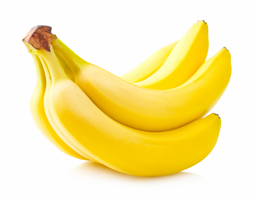

In [5]:
from fastdownload import download_url
dest = 'banana.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

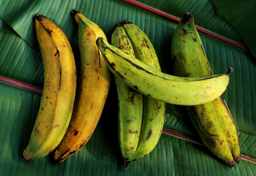

In [6]:
download_url(search_images('plantain fruit photos', max_images=1)[0], 'plantain.jpg', show_progress=False)
Image.open('plantain.jpg').to_thumb(256,256)

In [7]:
searches = 'banana','plantain'
path = Path('banana_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Train our model

In [8]:
# remove faulty images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

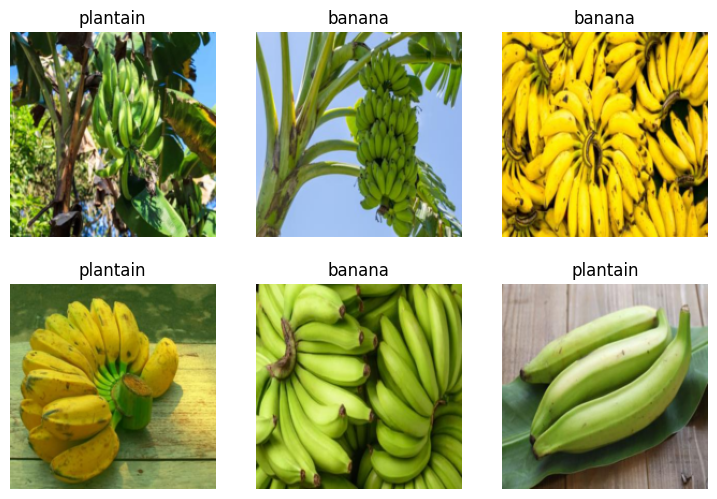

In [9]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.918503,0.324035,0.138889,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.413227,0.189454,0.097222,00:27
1,0.265652,0.328518,0.125000,00:27
2,0.208164,0.279410,0.097222,00:28


## Step 3: Use our model

This is a: banana.
Probability it's a banana: 0.9997


<Axes: >

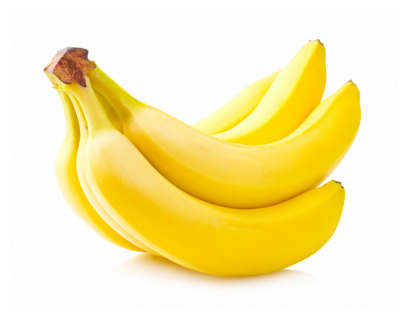

In [11]:
is_banana,_,probs = learn.predict(PILImage.create('banana.jpg'))
print(f"This is a: {is_banana}.")
print(f"Probability it's a banana: {probs[0]:.4f}")
PILImage.create('banana.jpg').show()